<table align="left"><td>
  <a target="_blank"  href="https://github.com/Dhruv0208/Research-Project/Autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/Dhruv0208/Research-Project/Autoencoder.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

In [1]:
# import sys
# !{sys.executable} -m pip install keras
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install imutils
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install --upgrade pip
# !{sys.executable} -m pip install -q tfds-nightly tensorflow
# !{sys.executable} -m pip install pydot
# !{sys.executable} -m pip install graphviz
# !{sys.executable} -m pip install pydotplus

In [2]:
import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.preprocessing.image import img_to_array
from keras.layers import Input
from keras.preprocessing import image
from keras import backend as K
from tensorflow.python.keras.utils.vis_utils import plot_model
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import numpy as np
import json
from functools import partial
import os
from imutils import paths
import cv2
import IPython.display as display
import multiprocessing

In [3]:
print(tf.__version__)

2.3.1


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}',format(device_name))

Found GPU at: {} /device:GPU:0


In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [512,512]
BATCH_SIZE = 4

In [6]:
file_pattern_train = f'coco/2017/1.1.0/coco-train.tfrecord*'
file_pattern_test = f'coco/2017/1.1.0/coco-test.tfrecord*'
file_pattern_valid = f'coco/2017/1.1.0/coco-validation.tfrecord*'
Training_filenames = tf.data.Dataset.list_files(file_pattern_train)
Test_filenames = tf.data.Dataset.list_files(file_pattern_test)
Valid_filenames = tf.data.Dataset.list_files(file_pattern_valid)
print("Train Tfrecords Files: ", len(Training_filenames))
print("Test Tfrecords Files: ", len(Test_filenames))
print("Valid Tfrecords Files: ", len(Valid_filenames))

Train Tfrecords Files:  256
Test Tfrecords Files:  64
Valid Tfrecords Files:  8


In [7]:
def decode_image(image):
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [*IMAGE_SIZE])
    paddings = tf.constant([[1,1], [1,1], [0,0]])
    image = tf.pad(image, paddings, "CONSTANT")
    image = tf.image.resize(image, [*IMAGE_SIZE])
    return image

In [8]:
def read_tfrecord(serialized_example):
    feature_description={
        "image": tf.io.FixedLenFeature([], tf.string,)
    }
    example = tf.io.parse_single_example(
    serialized_example, feature_description
    )
    image = decode_image(example['image'])
    return image

In [9]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(
        filenames)
    dataset = dataset.with_options(ignore_order)
    dataset =dataset.map(
        partial(read_tfrecord), num_parallel_calls=AUTOTUNE)
    return dataset

In [10]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(1024)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


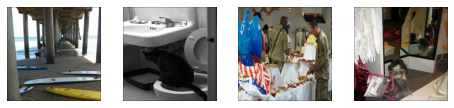

In [11]:
train_dataset = get_dataset(Training_filenames)
valid_dataset = get_dataset(Valid_filenames)
test_dataset = get_dataset(Test_filenames)
# train_dist_datset = strategy.experimental_distribute_dataset(train_dataset)
# test_dist_dataset = strategy.experimental_distribute_dataset(test_dataset)
# valid_dist_dataset = strategy.experimental_distribute_dataset(valid_dataset)
image_batch = next(iter(train_dataset))
def show_batch_original(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(5,5, n+1)
        print(image_batch[n].shape)
        plt.imshow(image_batch[n] / 255.0)
        plt.axis("off")
        
show_batch_original(image_batch.numpy())

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

## Preparing autoencoder

In [13]:
input_img = Input(shape=(512,512,3))
x = layers.Conv2D(256, (1,1), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding = 'same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
encoded = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(16, (3,3), activation='relu', padding='same')(encoded)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(16, (3,3), activation = 'relu', padding = 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(128, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(256, (3,3), activation = 'relu', padding= 'same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2,2))(x)
decoded = layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)


autoencoder = tf.keras.Model(inputs=input_img, outputs=decoded)


In [14]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 256)     1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 128)     295040    
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)     

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tfa.losses.SigmoidFocalCrossEntropy(from_logits=True)

## Extracting Features from intermediate layers

In [16]:
# intermediate_layer_model_1 = keras.Model(inputs=autoencoder.inputs,
#                                       outputs=autoencoder.get_layer('max_pooling2d_1').output)
# features_1 = intermediate_layer_model_1(train_ds)
# intermediate_layer_model_2 = keras.Model(inputs=autoencoder.inputs,
#                                       outputs=autoencoder.get_layer('max_pooling2d_3').output)
# features_2 = intermediate_layer_model_1(train_ds)
# intermediate_layer_model_3 = keras.Model(inputs=autoencoder.inputs,
#                                       outputs=autoencoder.get_layer('max_pooling2d_5').output)
# features_3 = intermediate_layer_model_1(train_ds)

## Training and testing the model

In [17]:
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model = autoencoder)
epochs = 2
for epoch in range(epochs):
    print("\n Start of epoch %d" % (epoch,))
    for step, x_batch_train in enumerate(train_dataset.take(800)):
        with tf.GradientTape() as tape:
            predictions = autoencoder(x_batch_train, training=True)
            loss_value = loss_fn(predictions, x_batch_train)
            
        grads = tape.gradient(loss_value, autoencoder.trainable_weights)
        optimizer.apply_gradients(zip(grads, autoencoder.trainable_weights))
#         if step&10000 == 0:
#             checkpoint.save(checkpoint_prefix)
        if step%100 == 0:
            print("Seen so far: %s samples" % ((step+1)*4))
            


 Start of epoch 0
Seen so far: 4 samples
Seen so far: 404 samples
Seen so far: 804 samples
Seen so far: 1204 samples
Seen so far: 1604 samples
Seen so far: 2004 samples
Seen so far: 2404 samples
Seen so far: 2804 samples

 Start of epoch 1
Seen so far: 4 samples
Seen so far: 404 samples
Seen so far: 804 samples
Seen so far: 1204 samples
Seen so far: 1604 samples
Seen so far: 2004 samples
Seen so far: 2404 samples
Seen so far: 2804 samples


In [18]:
# autoencoder.save('saved_model/AEncoder')

In [19]:
# autoencoder.save_weights("model.h5")

In [20]:
# model = keras.models.load_model('./saved_model/AEncoder')

In [21]:
images_batch_testing = next(iter(test_dataset))
predict = autoencoder.predict(images_batch_testing)

In [22]:
predict.shape

(4, 512, 512, 3)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


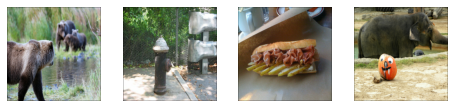

In [23]:
show_batch_original(images_batch_testing)

(512, 512, 3)
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)


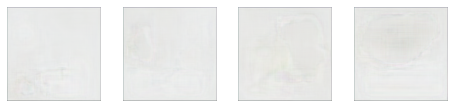

In [24]:
def show_batch_predict(predictionss):
    plt.figure(figsize=(10,10))
    for n in range(4):
        ax = plt.subplot(5,5, n+1)
        print(predictionss[n].shape)
        plt.imshow(predictionss[n])
        plt.axis("off")
show_batch_predict(predict)

In [25]:
predict[1]

array([[[0.2614248 , 0.31034148, 0.4517802 ],
        [0.29927737, 0.29308647, 0.50266886],
        [0.2527471 , 0.259766  , 0.47063607],
        ...,
        [0.3009634 , 0.28217915, 0.41074643],
        [0.34719342, 0.32580817, 0.5787346 ],
        [0.33189106, 0.24204455, 0.50398844]],

       [[0.42969036, 0.56044453, 0.4936702 ],
        [0.8912335 , 0.90387934, 0.8410133 ],
        [0.87755436, 0.919216  , 0.8698472 ],
        ...,
        [0.89966327, 0.90875506, 0.8697271 ],
        [0.9064954 , 0.9032617 , 0.9143692 ],
        [0.6097129 , 0.53572047, 0.62242126]],

       [[0.46954745, 0.52433145, 0.4999061 ],
        [0.92554766, 0.92446464, 0.88981855],
        [0.9164764 , 0.9496018 , 0.9162032 ],
        ...,
        [0.9151855 , 0.93526   , 0.89648634],
        [0.89595234, 0.92129153, 0.92021257],
        [0.49219954, 0.501686  , 0.5956709 ]],

       ...,

       [[0.43906546, 0.39755732, 0.54544264],
        [0.9116539 , 0.85101646, 0.8892077 ],
        [0.9327856 , 0